## Práctica Hive + Impala + HDFS + Spark + Hue

Para esta práctica voy a utilizar la VM con Hue, por lo tanto usaré este notebook únicamente para documentar paso a paso las querys que voy ejecutando.

### 1- Creación de tablas en formato texto

##### • 1.1) Crear Base de datos "datos_padron"

##### 1.2) Crear la tabla de datos padron_txt con todos los campos del fichero CSV y cargar los datos mediante el comando LOAD DATA LOCAL INPATH. La tabla tendrá formato texto y tendrá como delimitador de campo el caracter ';' y los campos que en el documento original están encerrados en comillas dobles '"' no deben estar envueltos en estos caracteres en la tabla de Hive (es importante indicar esto utilizando el serde de OpenCSV, si no la importación de las variables que hemos indicado como numéricas fracasará ya que al estar envueltos en comillas los toma como strings) y se deberá omitir la cabecera del fichero de datos al crear la tabla.

Con el código show create table padron_txt; podemos ver que la tabla fue guardada en formato txt. El problema es que al importar la tabla con el serde de opencsv no se puede cambiar a numérica las columnas de números, las toma como referencia tipo string. Este punto no lo consigo solucionar. He leído que para solucionarlo se debe crear una vista donde se castee los tipos que deseemos, pero claro está, que al realizar la vista obtenemos una tabla temporal y no la podremos guardar, o eso creo. 

##### • 1.3) Hacer trim sobre los datos para eliminar los espacios innecesarios guardando la tabla resultado como padron_txt_2. (Este apartado se puede hacer creando la tabla con una sentencia CTAS.)

En este punto hice trim y aproveché para castear las columnas numéricas que se encontraban de tipo string a int en una nueva tabla llamada padron_txt_2, el problema es que la creo y puedo ejecutar funciones más no se guarda la tabla, por ende no me sirve para lo que me piden. En el siguiente código intentaré crearla de otra forma.

Ahora con este código vemos como si se ejecuta y se guarda tal como lo requeríamos, haciendo trim y cast en las columnas descritas.

##### • 1.4) Investigar y entender la diferencia de incluir la palabra LOCAL en el comando LOAD DATA.

La diferencia está en si la ruta depende de hadoop o se encuentra de manera local

##### • 1.5) En este momento te habrás dado cuenta de un aspecto importante, los datos nulos de nuestras tablas vienen representados por un espacio vacío y no por un identificador de nulos comprensible para la tabla. Esto puede ser un problema para el tratamiento posterior de los datos. Podrías solucionar esto creando una nueva tabla utiliando sentencias case when que sustituyan espacios en blanco por 0. Para esto primero comprobaremos que solo hay espacios en blanco en las variables numéricas correspondientes a las últimas 4 variables de nuestra tabla (podemos hacerlo con alguna sentencia de HiveQL) y luego aplicaremos las sentencias case when para sustituir por 0 los espacios en blanco. (Pista: es útil darse cuenta de que un espacio vacío es un campo con longitud 0). Haz esto solo para la tabla padron_txt.

Comienzo dandome cuenta que la tabla padron_txt (donde todo es string) me aparecen los datos que debería cambiar a 0 como un espacio en blanco, en cambio, en la tabla padron_txt_2 donde los castee a tipo int me aparecen como NULL. La intención sería cambiar estos a 0.

##### • 1.6) Una manera tremendamente potente de solucionar todos los problemas previos (tanto las comillas como los campos vacíos que no son catalogados como null y los espacios innecesarios) es utilizar expresiones regulares (regex) que nos proporciona OpenCSV. Para ello utilizamos:
##### ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.RegexSerDe'
##### WITH SERDEPROPERTIES ('input.regex'='XXXXXXX')
##### Donde XXXXXX representa una expresión regular que debes completar y que identifique el formato exacto con el que debemos interpretar cada una de las filas de nuestro CSV de entrada. Para ello puede ser útil el portal "regex101". Utiliza este método para crear de nuevo la tabla padron_txt_2. Una vez finalizados todos estos apartados deberíamos tener una tabla padron_txt que conserve los espacios innecesarios, no tenga comillas envolviendo los campos y los campos nulos sean tratados como valor 0 y otra tabla padron_txt_2 sin espacios innecesarios, sin comillas envolviendo los campos y con los campos nulos como valor 0. Idealmente esta tabla ha sido creada con las regex de OpenCSV.

### 2- Investigamos el formato columnar parquet

##### • 2.1) ¿Qué es CTAS?

Es una manera de crear una nueva tabla partiendo como base de una tabla ya existente

##### • 2.2) Crear tabla Hive padron_parquet (cuyos datos serán almacenados en el formato columnar parquet) a través de la tabla padron_txt mediante un CTAS.

No estoy seguro que esta sea la forma coorecta de crear una tabla mediante un CTAS, en la siguiente pregunta si realizo esa creación de esa manera, pero en esta lo hago asi para tambien tener como ejemplo la creacion de una tabla y luego la introduccion de datos mediante el insert overwrite

##### • 2.3) Crear tabla Hive padron_parquet_2 a través de la tabla padron_txt_2 mediante un CTAS. En este punto deberíamos tener 4 tablas, 2 en txt (padron_txt y padron_txt_2, la primera con espacios innecesarios y la segunda sin espacios innecesarios) y otras dos tablas en formato parquet (padron_parquet y padron_parquet_2, la primera con espacios y la segunda sin ellos).

De la tabla padron_txt_2 (que tiene los tipos como son y trim en los strings) le voy a poner 0 en los valores null de los int, y generaré una nueva tabla formato parquet llamada padron_parquet_2:

##### • 2.4) Opcionalmente también se pueden crear las tablas directamente desde 0 (en lugar de mediante CTAS) en formato parquet igual que lo hicimos para el formato txt incluyendo la sentencia STORED AS PARQUET. Es importante para comparaciones posteriores que la tabla padron_parquet conserve los espacios innecesarios y la tabla padron_parquet_2 no los tenga. Dejo a tu elección cómo hacerlo.

Esto fue lo descrito en el ejercicio 2.2, me adelante sin querer.

##### • 2.5) Investigar en qué consiste el formato columnar parquet y las ventajas de trabajar con este tipo de formatos.

Es un formato columnar, comprimido (binario). Utiliza record-shredding para almacenar tipos de datos complejos y anidados (un CSV no es capaz).

Almacena el esquema junto a los datos. También máx/mín por columna (resúmenes).

Los valores de cada columna se guardan físicamente juntos (almacenamiento columnar). 

Beneficios:  
    * Compresión de datos por cada columna para ahorrar espacio.  
    * Se pueden aplicar técnicas de compresión diferentes, específicas según el   tipo de dato que almacena cada columna.  
    * Las consultas con filtrados sobre columnas concretas no necesitan leer toda la fila, mejorando el rendimiento.  

Preparado para añadir más esquemas de codificación que se desarrollen en el futuro.  

No requiere especificar separador de columnas, ni si se incluyen o no nombres de columna(siempre se incluyen por defecto).

Es con diferencia el formato más ampliamente utilizado para procesamiento en batch, tanto paradatos de entrada como para guardar resultados, con datos estructurados.

##### • 2.6) Comparar el tamaño de los ficheros de los datos de las tablas padron_txt (txt), padron_txt_2 (txt pero no incluye los espacios innecesarios), padron_parquet y padron_parquet_2 (alojados en hdfs cuya ruta se puede obtener de la propiedad location de cada tabla por ejemplo haciendo "show create table").

1) padron_txt:  
    * LOCATION: 'hdfs://quickstart.cloudera:8020/user/hive/warehouse/datos_padron.db/padron_txt'  
    * total Size: 22586201  
2) padron_txt_2:  
    * LOCATION: 'hdfs://quickstart.cloudera:8020/user/hive/warehouse/datos_padron.db/padron_txt_2'  
    * total Size: 12712946  
3) padron_parquet:  
    * LOCATION: 'hdfs://quickstart.cloudera:8020/user/hive/warehouse/datos_padron.db/padron_parquet'  
    * total Size: 875893  
4) padron_parquet_2:  
    * LOCATION: 'hdfs://quickstart.cloudera:8020/user/hive/warehouse/datos_padron.db/padron_parquet_2'  
    * total Size: 938395  

Vemos como el tamaño de las tablas parquet ocupan mucho menos que las de tipo text file

### 3- Juguemos con Impala.

##### • 3.1) ¿Qué es Impala?

Motor SQL de elevado performance pensada para operar sobre grandes volúmenes de datos. El motor es procesamiento masivo en
paralelo con latencias en milisegundos.
Puede ejecutar queries sobre HDFS o Hbase.
Desarrollada por cloudera

##### • 3.2) ¿En qué se diferencia de Hive?

Ejecuta las queries sobre el cluster en lugar de ejecutar MapReduce para procesar como es el caso de Hive, y debido a ello es en torno a unas 5 veces más rápido, aunque puede llegar a serlo hasta 20 veces más. Pero no es tan seguro. Así que si buscamos velocidad y no importa la seguridad podemos trabajar con Impala, pero si la seguridad es importante entonces es mejor ir lento pero seguros con Hive.

##### • 3.3) Comando INVALIDATE METADATA, ¿en qué consiste?

Se utiliza para actualizar los metadatos de toda la base de datos o una tabla, incluidos los metadatos de la tabla y los datos del archivo en la tabla. Primero borrará la memoria caché de la tabla y luego volverá a cargar todos los datos de la store de metadatos y la memoria caché. Esta operación es relativamente cara. Se utiliza principalmente para modificar los metadatos de la tabla en Hive, y debe sincronizarse para impala.

Ejemplos:  
INVALIDATE METADATA; // Recargar todas las tablas en todas las bibliotecas  
INVALIDATE METADATA [table]; // Recargar una tabla especificada

##### • 3.4) Hacer invalidate metadata en Impala de la base de datos datos_padron.

Desde la shell en la VM:  
    1) impala-shell  
    2) use datos_padron;  
    3) invalidate metadata;  

Me salió como resultado: Fetched 0 row(s) in 2.22s

##### • 3.5) Calcular el total de EspanolesHombres, espanolesMujeres, ExtranjerosHombres y ExtranjerosMujeres agrupado por DESC_DISTRITO y DESC_BARRIO.

select sum(espanoleshombres) , sum(espanolesmujeres), sum(extranjeroshombres), sum(extranjerosmujeres)
from padron_txt_2
group by desc_distrito, desc_barrio;

##### • 3.6) Llevar a cabo las consultas en Hive en las tablas padron_txt_2 y padron_parquet_2 (No deberían incluir espacios innecesarios). ¿Alguna conclusión?

select desc_distrito,  
       desc_barrio,  
       sum(espanoleshombres) as espanoleshombres,  
       sum(espanolesmujeres) as espanolesmujeres,  
       sum(extranjeroshombres) as extranjeroshombres,  
       sum(extranjerosmujeres) as extranjerosmujeres  
from padron_parquet_2  
group by desc_distrito, desc_barrio;

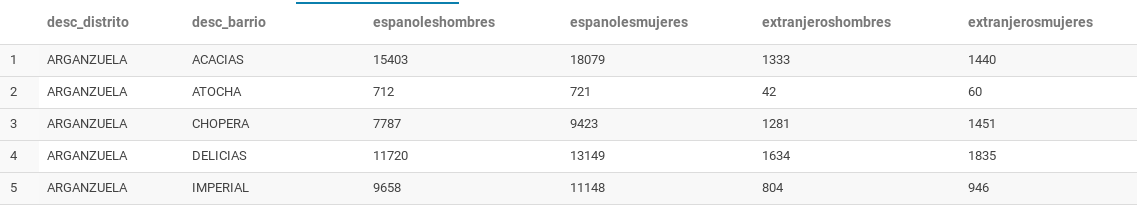

select desc_distrito,  
       desc_barrio,  
       sum(espanoleshombres) as espanoleshombres,  
       sum(espanolesmujeres) as espanolesmujeres,  
       sum(extranjeroshombres) as extranjeroshombres,  
       sum(extranjerosmujeres) as extranjerosmujeres  
from padron_txt_2  
group by desc_distrito, desc_barrio;

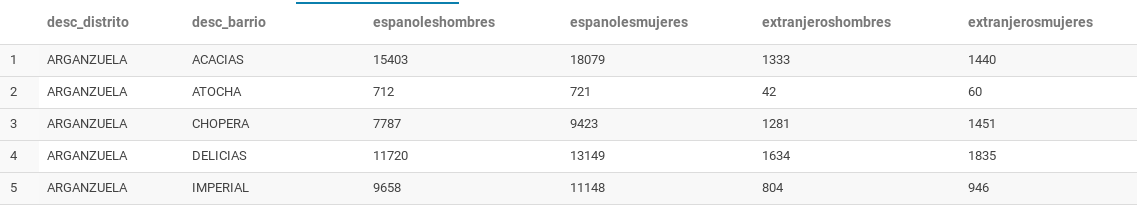

Para ver la diferencia entre ambas tablas podemos hacer un count, ya que por lo que entiendo parquet toma en cuenta los valores en 0 (nulos) y la de txt no los toma en cuenta. Recordar que así las hemos creado.

select count(espanoleshombres) , count(espanolesmujeres), count(extranjeroshombres), count(extranjerosmujeres)  
from padron_txt_2  
group by desc_distrito, desc_barrio;

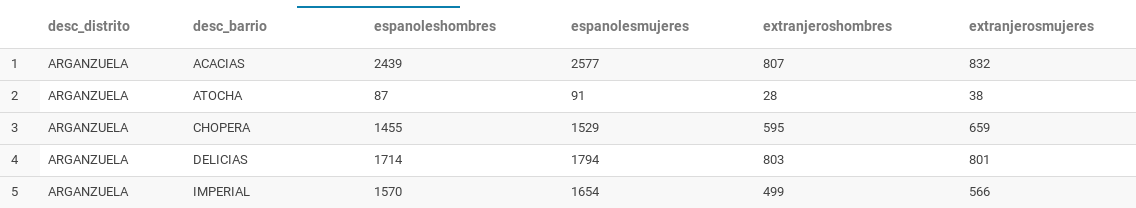

select count(espanoleshombres) , count(espanolesmujeres), count(extranjeroshombres), count(extranjerosmujeres)  
from padron_parquet_2  
group by desc_distrito, desc_barrio;

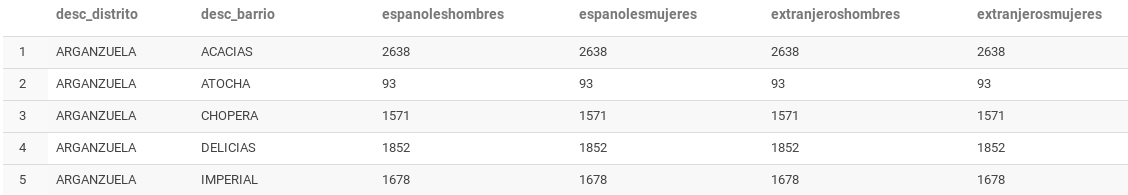


##### • 3.7) Llevar a cabo la misma consulta sobre las mismas tablas en Impala. ¿Alguna conclusión?

Me parecen dos conclusiones:  
    1) La velocidad en la ejecución de la query.  
    2) En Hive el resultado ya lo obtengo ordenado, en Impala tuve que agregarle un order by para que me diera el resultado que estaba obteniendo en Hive.

##### • 3.8) ¿Se percibe alguna diferencia de rendimiento entre Hive e Impala?

Impala es bastante más rápido que Hive.

### 4- Sobre tablas particionadas.

##### • 4.1) Crear tabla (Hive) padron_particionado particionada por campos DESC_DISTRITO y DESC_BARRIO cuyos datos estén en formato parquet.

CREATE TABLE IF NOT EXISTS padron_particionado
(DESC_DISTRITO String,
COD_DIST_BARRIO Int,
DESC_BARRIO String,
COD_DIST_SECCION Int,
COD_SECCION Int,
COD_EDAD_INT Int,
EspanolesHombres Int,
EspanolesMujeres Int,
ExtranjerosHombres Int,
ExtranjerosMujeres Int)
partitioned by (COD_DISTRITO Int, COD_BARRIO Int)
stored as parquet; 

##### • 4.2) Insertar datos (en cada partición) dinámicamente (con Hive) en la tabla recién creada a partir de un select de la tabla padron_parquet_2.

from datos_padron.padron_parquet_2 insert overwrite table datos_padron.padron_particionado partition(COD_DISTRITO, COD_BARRIO) select *;  

Llegado a este punto no lograba introducirle los datos a la tabla y siempre me generaba error, por lo que tuve que ejecutar estas 7 siguientes líneas de código:  

SET hive.exec.dynamic.partition=true;  
SET hive.exec.dynamic.partition.mode=non-strict;  
SET hive.exec.max.dynamic.partitions = 10000;  
SET hive.exec.max.dynamic.partitions.pernode = 1000;  
SET mapreduce.map.memory.mb = 2048;  
SET mapreduce.reduce.memory.mb = 2048;  
SET mapreduce.map.java.opts=-Xmx1800m;  


##### • 4.3) Hacer invalidate metadata en Impala de la base de datos padron_particionado.

Desde Impala..

INVALIDATE METADATA datos_padron.padron_particionado;

##### • 4.4) Calcular el total de EspanolesHombres, EspanolesMujeres, ExtranjerosHombres y ExtranjerosMujeres agrupado por DESC_DISTRITO y DESC_BARRIO para los distritos CENTRO, LATINA, CHAMARTIN, TETUAN, VICALVARO y BARAJAS.

select desc_distrito, desc_barrio, sum(espanoleshombres) as espanoleshombres, sum(espanolesmujeres) as espanolesmujeres, sum(extranjeroshombres) as extranjeroshombres, sum(extranjerosmujeres) as extranjerosmujeres  
from padron_parquet_2  
group by desc_distrito, desc_barrio  
having desc_distrito IN ('CENTRO','LATINA','CHAMARTIN','TETUAN','VICALVARO','BARAJAS');

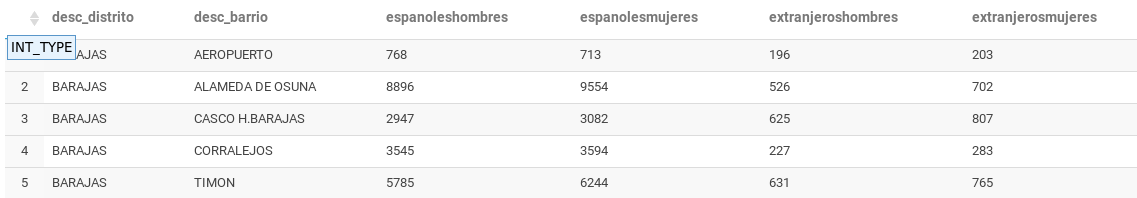

select desc_distrito, desc_barrio, sum(espanoleshombres) as espanoleshombres, sum(espanolesmujeres) as espanolesmujeres, sum(extranjeroshombres) as extranjeroshombres, sum(extranjerosmujeres) as extranjerosmujeres  
from padron_parquet_2  
where desc_distrito IN ('CENTRO','LATINA','CHAMARTIN','TETUAN','VICALVARO','BARAJAS')  
group by desc_distrito, desc_barrio;

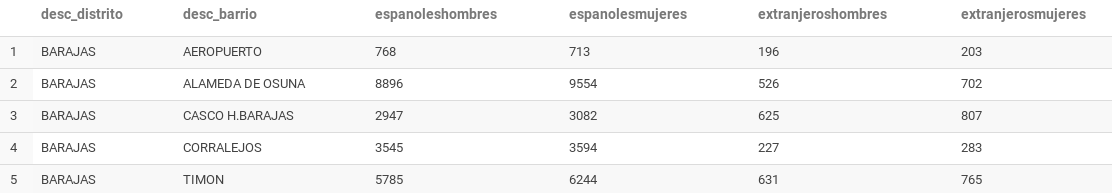

###### • 4.5) Llevar a cabo la consulta en Hive en las tablas padron_parquet y padron_partitionado. ¿Alguna conclusión?

Query 1:  
select desc_distrito, desc_barrio, sum(espanoleshombres) as espanoleshombres, sum(espanolesmujeres) as espanolesmujeres, sum(extranjeroshombres) as extranjeroshombres, sum(extranjerosmujeres) as extranjerosmujeres  
from padron_particionado  
group by desc_distrito, desc_barrio  
having desc_distrito IN ('CENTRO','LATINA','CHAMARTIN','TETUAN','VICALVARO','BARAJAS');

Query 2:  
select desc_distrito, desc_barrio, sum(espanoleshombres) as espanoleshombres, sum(espanolesmujeres) as espanolesmujeres, sum(extranjeroshombres) as extranjeroshombres, sum(extranjerosmujeres) as extranjerosmujeres  
from padron_parquet_2  
group by desc_distrito, desc_barrio  
having desc_distrito IN ('CENTRO','LATINA','CHAMARTIN','TETUAN','VICALVARO','BARAJAS');

Query 3:  
select cod_distrito, cod_barrio, sum(espanoleshombres) as espanoleshombres, sum(espanolesmujeres) as espanolesmujeres, sum(extranjeroshombres) as extranjeroshombres, sum(extranjerosmujeres) as extranjerosmujeres  
from padron_parquet_2  
where cod_distrito IN (1, 5, 10, 19, 6, 21)  
group by cod_distrito, cod_barrio;

Query 4:  
select cod_distrito, cod_barrio, sum(espanoleshombres) as espanoleshombres, sum(espanolesmujeres) as espanolesmujeres, sum(extranjeroshombres) as extranjeroshombres, sum(extranjerosmujeres) as extranjerosmujeres  
from padron_particionado  
where cod_distrito IN (1, 5, 10, 19, 6, 21)  
group by cod_distrito, cod_barrio;

En las primeras 2 querys trabajo sobre el ejemplo que hace referencia el ejercicio, y en las ultimas 2 querys trabajo sobre la partición que terminé realizando, debido a que al final hice una partición diferente, tomando en cuenta los cod en vez de los desc (por temas de utf-8). 

NOTA:
Debido a esto observé que la query que menos tardaba era la 3, por lo que me llamó la atención que no fue la query que trabaja los datos particionados en la tabla padron_particionado, ya que trabajo sobre una busqueda de datos particionados, el tema está en que los datos son muy pequeños y tarda más buscando en particiones que ejecutándolo como un todo. Si trabajamos con teras de información si vamos a poder ver que va a tardar menos en tablas particionadas que en las no particionadas. La que más tardaba era la query 1 ya que buscaba unos datos que no tenían que ver sobre la partición en una tabla particionada.

##### • 4.6) Llevar a cabo la consulta en Impala en las tablas padron_parquet y padron_particionado. ¿Alguna conclusión?

Lo que en Hive tarda entre 25 y 40 segundos aprox en Impala tarda como mucho 1 seg.

##### • 4.7) Hacer consultas de agregación (Max, Min, Avg, Count) tal cual el ejemplo anterior con las 3 tablas (padron_txt_2, padron_parquet_2 y padron_particionado) y comparar rendimientos tanto en Hive como en Impala y sacar conclusiones.

HIVE.

(Tardó 24.67s)
select cod_distrito,   
       cod_barrio,   
       max(espanoleshombres) as maxEspH,   
       max(espanolesmujeres) as maxEspM,   
       max(extranjeroshombres) as maxExtH,   
       max(extranjerosmujeres) as maxExtM,  
       min(espanoleshombres) as minEspH,   
       min(espanolesmujeres) as minEspM,   
       min(extranjeroshombres) as minExtH,   
       min(extranjerosmujeres) as minExtM,  
       avg(espanoleshombres) as avgEspH,   
       avg(espanolesmujeres) as avgEspM,   
       avg(extranjeroshombres) as avgExtH,   
       avg(extranjerosmujeres) as avgExtM,  
       count(espanoleshombres) as countEspH,   
       count(espanolesmujeres) as countEspM,   
       count(extranjeroshombres) as countExtH,   
       count(extranjerosmujeres) as countExtM  
from padron_particionado  
where cod_distrito IN (1, 5, 10, 19, 6, 21)  
group by cod_distrito, cod_barrio;  

En la tabla padron_parquet_2 tardó 25.91s

En la tabla padron_txt_2 tardó 24.58s aunque los resultados fueron diferentes ya que existen nulos en las columnas (en esta nunca cambié los nulos a 0)

IMPALA.
(Tardó 1.4s)
select cod_distrito,   
       cod_barrio,   
       max(espanoleshombres) as maxEspH,   
       max(espanolesmujeres) as maxEspM,   
       max(extranjeroshombres) as maxExtH,   
       max(extranjerosmujeres) as maxExtM,  
       min(espanoleshombres) as minEspH,   
       min(espanolesmujeres) as minEspM,   
       min(extranjeroshombres) as minExtH,   
       min(extranjerosmujeres) as minExtM,  
       avg(espanoleshombres) as avgEspH,   
       avg(espanolesmujeres) as avgEspM,   
       avg(extranjeroshombres) as avgExtH,   
       avg(extranjerosmujeres) as avgExtM,  
       count(espanoleshombres) as countEspH,   
       count(espanolesmujeres) as countEspM,   
       count(extranjeroshombres) as countExtH,   
       count(extranjerosmujeres) as countExtM  
from padron_particionado  
where cod_distrito IN (1, 5, 10, 19, 6, 21)  
group by cod_distrito, cod_barrio;  

En la tabla padron_parquet_2 tardó 0s

En la tabla padron_txt_2 tardó 0s aunque los resultados fueron diferentes ya que existen nulos en las columnas (en esta nunca cambié los nulos a 0)

Sin duda alguna, y como sabemos, Impala es mucho más rápido que Hive.

### 5- Trabajando con tablas en HDFS. A continuación vamos a hacer una inspección de las tablas, tanto externas (no gestionadas) como internas (gestionadas). Este apartado se hará si se tiene acceso y conocimiento previo sobre cómo insertar datos en HDFS.

##### • 5.1) Crear un documento de texto en el almacenamiento local que contenga una secuencia de números distribuidos en filas y separados por columnas, llámalo datos1 y que sea por ejemplo:  
1,2,3  
4,5,6  
7,8,9  

Desde la carpeta de virtualBox en la terminal ejecuto las siguientes líneas:

cat > dtos1.txt (pulsar intro)   
    1,2,3 (pulsar intro)   
    4,5,6 (pulsar intro)   
    7,8,9 (pulsar intro)   
    (pulsar Control+Z)  

##### • 5.2) Crear un segundo documento (datos2) con otros números pero la misma estructura.

Desde la carpeta de virtualBox en la terminal ejecuto las siguientes líneas:

cat > datos2.txt (pulsar intro)   
    10,20,30 (pulsar intro)   
    40,50,60 (pulsar intro)   
    70,80,90 (pulsar intro)   
    (pulsar Control+Z)  

##### • 5.3) Crear un directorio en HDFS con un nombre a placer, por ejemplo, /test. Si estás en una máquina Cloudera tienes que asegurarte de que el servicio HDFS está activo ya que puede no iniciarse al encender la máquina (puedes hacerlo desde el Cloudera Manager). A su vez, en las máquinas Cloudera es posible (dependiendo de si usamos Hive desde consola o desde Hue) que no tengamos permisos para crear directorios en HDFS salvo en el directorio /user/cloudera.

desde la ruta en /user/cloudera escribí la siguiente línea:

hdfs dfs -mkdir ejer5padron

##### • 5.4) Mueve tu fichero datos1 al directorio que has creado en HDFS con un comando desde consola.

hdfs dfs -put /media/sf_VirtualBox/dtos1.txt /user/cloudera/ejer5padron

##### • 5.5) Desde Hive, crea una nueva database por ejemplo con el nombre numeros. Crea una tabla que no sea externa y sin argumento location con tres columnas numéricas, campos separados por coma y delimitada por filas. La llamaremos por ejemplo numeros_tbl.

Desde Hue:  

create database if not exists numeros;

create table if not exists numeros.numerostbl  
(columna1 int,  
columna2 int,  
columna3 int)  
row format delimited fields terminated by ',';

##### • 5.6) Carga los datos de nuestro fichero de texto datos1 almacenado en HDFS en la tabla de Hive. Consulta la localización donde estaban anteriormente los datos almacenados. ¿Siguen estando ahí? ¿Dónde están?. Borra la tabla, ¿qué ocurre con los datos almacenados en HDFS?

load data inpath '/user/cloudera/ejer5padron/dtos1.txt' overwrite into table numeros.numerostbl;

En Hive me dejó, pero en Impala (solo por probar) me arrojó este error:  
AnalysisException: Unable to LOAD DATA from hdfs://quickstart.cloudera:8020/user/cloudera/ejer5padron/dtos1.txt because Impala does not have WRITE permissions on its parent directory hdfs://quickstart.cloudera:8020/user/cloudera/ejer5padron 

Revisé la tabla en Hue y se hizo perfecto el load data.

Ya el archivo no se encuentra donde estaba dentro de hdfs.

Borro la tabla como me lo indica el enunciado: drop table numerostbl;

Ya no veo los datos almacenados en hdfs.

##### • 5.7) Vuelve a mover el fichero de texto datos1 desde el almacenamiento local al directorio anterior en HDFS.

hdfs dfs -put /media/sf_VirtualBox/dtos1.txt /user/cloudera/ejer5padron

##### • 5.8) Desde Hive, crea una tabla externa sin el argumento location. Y carga datos1 (desde HDFS) en ella. ¿A dónde han ido los datos en HDFS? Borra la tabla ¿Qué ocurre con los datos en hdfs?

Desde Hue:  

create external table if not exists numeros.numerostblext  
(columna1 int,  
columna2 int,  
columna3 int)  
row format delimited fields terminated by ',';

load data inpath '/user/cloudera/ejer5padron/dtos1.txt' overwrite into table numeros.numerostblext;

Los datos ya no se encuentran en la ruta de hdfs, que sería /user/cloudera/ejer5padron

Pero como creamos la tabla externa ahora el archivo lo tenemos en user/hive/warehouse/numerosdb/numerostblext/dtos1.txt

Es decir, de hdfs pasó a la ruta del warehouse de hive almacenandose en la tabla

Ahora borramos la tabla:
drop table numerostblext;

Vemos como a diferencia de la creación de la tabla local, al momento de borrar una tabla se borra toda la info en hdfs y tuvimos que volver a copiar el archivo para volver a ejecutar todos los pasos pero ahora guardándolos en una tabla externa, que al momento de borrarla la tabla de la base de datos en hive aún seguíamos teniando los datos en hdfs.

##### • 5.9) Borra el fichero datos1 del directorio en el que estén. Vuelve a insertarlos en el directorio que creamos inicialmente (/test). Vuelve a crear la tabla numeros desde hive pero ahora de manera externa y con un argumento location que haga referencia al directorio donde los hayas situado en HDFS (/test). No cargues los datos de ninguna manera explícita. Haz una consulta sobre la tabla que acabamos de crear que muestre todos los registros. ¿Tiene algún contenido?

hdfs dfs -rm /user/hive/warehouse/numeros.db/numerostblext/dtos1.txt

hdfs dfs -put /media/sf_VirtualBox/dtos1.txt /user/cloudera/ejer5padron

CREATE EXTERNAL TABLE numeros_tbl(
columna1 int,
columna2 int,
columna3 int)
LOCATION '/user/cloudera/ejer5padron';

Al hacer la consulta:  
select *  
from  numeros_tbl;  

Los campos me aparecen null, salen las 3 columnas y 4 filas.

##### • 5.10) Inserta el fichero de datos creado al principio, "datos2" en el mismo directorio de HDFS que "datos1". Vuelve a hacer la consulta anterior sobre la misma tabla. ¿Qué salida muestra?

hdfs dfs -put /media/sf_VirtualBox/datos2.txt /user/cloudera/ejer5padron

Hacemos la consulta:  
select *  
from numeros_tbl;

Vuelve a mostrar tantas filas como reconoce de los archivos existentes de la ruta, pero las muestra en null ya que no le hemos insertado los archivos explicítamente.

##### • 5.11) Extrae conclusiones de todos estos anteriores apartados.

Vemos como al ejecutar la query de pedirle toda la info nos muestra las filas que sabe que existen en los datos de la ruta de ejer5padron, que tiene dtos1.txt y datos2.txt, es decir, muestra 6 filas con puros null, al principio 3 y al agregarle datos2 muestra 3 más. Reconoce que existe en esa ruta esa cantidad de filas provenientes de los archivos existentes en la misma pero como no los hemos cargado explicítamente no nos muestra la info de los mismos.

### 6- Un poquito de Spark.

##### La siguiente sección de la práctica se abordará si ya se tienen suficientes conocimientos de Spark, en concreto de el manejo de DataFrames, y el manejo de tablas de Hive a través de Spark.sql.

##### • 6.1) Comenzamos realizando la misma práctica que hicimos en Hive en Spark, importando el csv. Sería recomendable intentarlo con opciones que quiten las "" de los campos, que ignoren los espacios innecesarios en los campos, que sustituyan los valores vacíos por 0 y que infiera el esquema

Adrián me comentó que pusiera el archivo hive-site.xml que se encuentra en la ruta /etc/hive/conf a mi carpeta de Spark/conf. Por lo tanto ejecuto esta línea en la shell:

cp /etc/hive/conf/hive-site.xml /media/sf_VirtualBox

Y luego en la carpeta VirtualBox de mi desktop conpie el archivo y lo pegue en C:Spark/conf

Esto lo hago para poder crear bases de datos y tablas en Hive desde el notebook.

In [37]:
from os.path import abspath

from pyspark.sql import SparkSession
from pyspark.sql import Row

# warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL Hive integration example") \
#    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()


AnalysisException: java.lang.RuntimeException: The root scratch dir: /tmp/hive on HDFS should be writable. Current permissions are: rw-rw-rw-

In [ ]:
spark.stop()

In [ ]:
# spark is an existing SparkSession
spark.sql("CREATE TABLE IF NOT EXISTS desdeNotebook (columna1 int,columna2 int,columna3 int) USING hive")
spark.sql("LOAD DATA LOCAL INPATH '/user/cloudera/ejer5padron/datos3.txt' INTO TABLE desdeNotebook")

# Queries are expressed in HiveQL
spark.sql("SELECT * FROM desdeNotebook").show()

In [38]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
# Create a SparkSession
spark = (SparkSession
 .builder
 .appName("SparkPadron")
 .master("local")
 .enableHiveSupport()
 .getOrCreate())

In [39]:
csv_file = "Rango_Edades_Seccion_202106.csv"

In [40]:
df = (spark.read.format("csv")
 .option("inferSchema", "true")
 .option("header", "true")
 .option("quote", '"')
 .option("escape", '"')
 .option("emptyValue","0")
 .load(csv_file))

In [41]:
df.columns

['"COD_DISTRITO";"DESC_DISTRITO";"COD_DIST_BARRIO";"DESC_BARRIO";"COD_BARRIO";"COD_DIST_SECCION";"COD_SECCION";"COD_EDAD_INT";"EspanolesHombres";"EspanolesMujeres";"ExtranjerosHombres";"ExtranjerosMujeres"']

In [42]:
df.select("DESC_DISTRITO","COD_BARRIO","EspanolesHombres","ExtranjerosMujeres")

AnalysisException: cannot resolve '`DESC_DISTRITO`' given input columns: ["COD_DISTRITO";"DESC_DISTRITO";"COD_DIST_BARRIO";"DESC_BARRIO";"COD_BARRIO";"COD_DIST_SECCION";"COD_SECCION";"COD_EDAD_INT";"EspanolesHombres";"EspanolesMujeres";"ExtranjerosHombres";"ExtranjerosMujeres"];
'Project ['DESC_DISTRITO, 'COD_BARRIO, 'EspanolesHombres, 'ExtranjerosMujeres]
+- Relation["COD_DISTRITO";"DESC_DISTRITO";"COD_DIST_BARRIO";"DESC_BARRIO";"COD_BARRIO";"COD_DIST_SECCION";"COD_SECCION";"COD_EDAD_INT";"EspanolesHombres";"EspanolesMujeres";"ExtranjerosHombres";"ExtranjerosMujeres"#136] csv


##### • 6.2) De manera alternativa también se puede importar el csv con menos tratamiento en la importación y hacer todas las modificaciones para alcanzar el mismo estado de limpieza de los datos con funciones de Spark.

##### • 6.3) Enumera todos los barrios diferentes.

##### • 6.4) Crea una vista temporal de nombre "padron" y a través de ella cuenta el número de barrios diferentes que hay.

##### • 6.5) Crea una nueva columna que muestre la longitud de los campos de la columna DESC_DISTRITO y que se llame "longitud".

##### • 6.6) Crea una nueva columna que muestre el valor 5 para cada uno de los registros de la tabla. 

##### • 6.7) Borra esta columna.

##### • 6.8) Particiona el DataFrame por las variables DESC_DISTRITO y DESC_BARRIO.

##### • 6.9) Almacénalo en caché. Consulta en el puerto 4040 (UI de Spark) de tu usuario local el estado de los rdds almacenados.

##### • 6.10) Lanza una consulta contra el DF resultante en la que muestre el número total de "espanoleshombres", "espanolesmujeres", extranjeroshombres" y "extranjerosmujeres" para cada barrio de cada distrito. Las columnas distrito y barrio deben ser las primeras en aparecer en el show. Los resultados deben estar ordenados en orden de más a menos según la columna "extranjerosmujeres" y desempatarán por la columna "extranjeroshombres".

##### • 6.11) Elimina el registro en caché.

##### • 6.12) Crea un nuevo DataFrame a partir del original que muestre únicamente una columna con DESC_BARRIO, otra con DESC_DISTRITO y otra con el número total de "espanoleshombres" residentes en cada distrito de cada barrio. Únelo (con un join) con el DataFrame original a través de las columnas en común.

##### • 6.13) Repite la función anterior utilizando funciones de ventana. (over(Window.partitionBy.....)).

##### • 6.14) Mediante una función Pivot muestra una tabla (que va a ser una tabla de contingencia) que contenga los valores totales ()la suma de valores) de espanolesmujeres para cada distrito y en cada rango de edad (COD_EDAD_INT). Los distritos incluidos deben ser únicamente CENTRO, BARAJAS y RETIRO y deben figurar como columnas . El aspecto debe ser similar a este:  
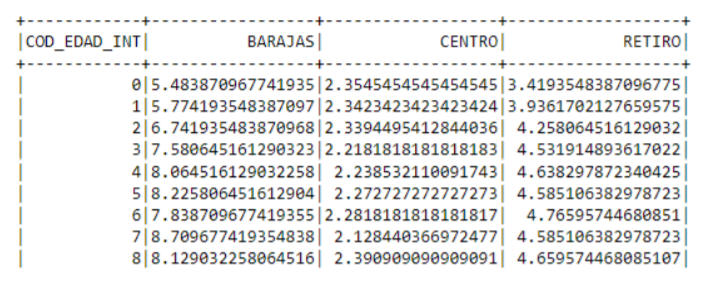

##### • 6.15) Utilizando este nuevo DF, crea 3 columnas nuevas que hagan referencia a qué porcentaje de la suma de "espanolesmujeres" en los tres distritos para cada rango de edad representa cada uno de los tres distritos. Debe estar redondeada a 2 decimales. Puedes imponerte la condición extra de no apoyarte en ninguna columna auxiliar creada para el caso.

##### • 6.16) Guarda el archivo csv original particionado por distrito y por barrio (en ese orden) en un directorio local. Consulta el directorio para ver la estructura de los ficheros y comprueba que es la esperada.

##### • 6.17) Haz el mismo guardado pero en formato parquet. Compara el peso del archivo con el resultado anterior.

### 7- ¿Y si juntamos Spark y Hive?  
##### • 7.1) Por último, prueba a hacer los ejercicios sugeridos en la parte de Hive con el csv "Datos Padrón" (incluyendo la importación con Regex) utilizando desde Spark EXCLUSIVAMENTE sentencias spark.sql, es decir, importar los archivos desde local directamente como tablas de Hive y haciendo todas las consultas sobre estas tablas sin transformarlas en ningún momento en DataFrames ni DataSets.